# The Hodgkin-Huxley model


The **Hodgkin-Huxley model**, or **conductance-based model**, is a mathematical model that describes how action potentials in neurons are initiated and propagated. In essence, it is a set of nonlinear differential equations that approximate the electrical characteristics of excitable neuron cells.

## Basic components

The typical Hodgkin-Huxley model treats each component of an excitable cell as an electrical element (as shown in the figure below)

![inline 30%](model.png)

* The lipid bilayer is represented as a capacitance $ C_m $
* Voltage-gated ion channels are represented by electrical conductances $g_n$ (where $n$ is the specific ion channel) that depend on both voldate and time
* Leak channels are represented by linear conductances $g_L$
* The electrochemical gradients driving the flow of ions are represented by voltage sources $E_n$ whose voltages are determined by the ratio of the intra- and extracellular concentrations of the ionice species of interest
* Ion pumps are represented by current sources $I_p$
* The membrane potential is denoted by $V_m$

Mathematically, the current flowing through the lipid bilayer is written as

$$I_c = C_m \frac{d V_m}{d t}$$

and the current through a given ion channel is the product

$$I_i = g_n (V_m - V_i)$$

where $V_i$ is the reversal potential of the $i$-th ion channel. Thus, for a cell with sodium ($Na^{+}$) and potassium ($K^{+}$) channels, the total current through the membrane is given by

$$I = C_m \frac{d V_m}{d t} + g_K (V_m - V_K) + g_{Na} (V_m - V_{Na}) + g_l (V_m - V_l)$$

where $I$ is the total membrane current per unit area, $C_m$ is the membrane capacitance per unit area, $g_K$ and $g_{Na}$ are the potassium and sodium conductances per unit area, respectively, $V_K$ and $V_{Na}$ are the potassium and sodium reversal potentials, respectively, and $g_l$ and $V_l$ are the leak conductance per unit area and leak reversal potential, respectively. 

The time dependent elements of this equation are $V_m$, $g_{Na}$, and $g_{K}$, where the last two conductances depend explicitly on voltage as well.

## Voltage-gated ion channels

The total current can be computed as follows:

$$I = C_m \frac{d V_m}{d t} + \bar{g}_K n^4 (V_m - V_K) + \bar{g}_{Na} m^3 h (V_m - V_{Na}) + \bar{g}_l (V_m - V_l)$$

$$\frac{d n}{d t} = \alpha_n(V_m)(1-n) - \beta_n(V_m) n$$

$$\frac{d m}{d t} = \alpha_m(V_m)(1-m) - \beta_m(V_m) m$$

$$\frac{d h}{d t} = \alpha_h(V_m)(1-h) - \beta_h(V_m) h$$

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division
%matplotlib inline

In [20]:
# maximum conductances
g_Na = 120
g_K = 36
g_l = 0.3

# reversal potentials
V_Na = 115
V_K = -12
V_l = 10.613

# membrane capacitance
C_m = 1

In [21]:
def alpha_n(V_m):
    return 0.01 * (-V_m + 10) / (np.exp((-V_m + 10) / 10) - 1)

def beta_n(V_m):
    return 0.125 * np.exp(-V_m / 80)

def n_inf(V_m):
    return alpha_n(V_m) / (alpha_n(V_m) + beta_n(V_m))

def alpha_m(V_m):
    return 0.1 * (-V_m + 25) / (np.exp((-V_m + 25) / 10) - 1 )

def beta_m(V_m):
    return 4 * np.exp(-V_m / 18)

def m_inf(V_m):
    return alpha_m(V_m) / (alpha_m(V_m) + beta_m(V_m))

def alpha_h(V_m):
    return 0.07 * np.exp(-V_m / 20)

def beta_h(V_m):
    return 1 / (np.exp((-V_m + 30) / 10) + 1)

def h_inf(V_m):
    return alpha_h(V_m) / (alpha_h(V_m) + beta_h(V_m))

def I_Na(V_m, m, h):
    return g_Na * (m ** 3) * h * (V_m - V_Na)

def I_K(V_m, n):
    return g_K * (n ** 4) * (V_m - V_K)

def I_L(V_m):
    return g_l * (V_m - V_l)

def dndt(V_m, n):
    return alpha_n(V_m) * (1 - n) - beta_n(V_m) * n

def dmdt(V_m, m):
    return alpha_m(V_m) * (1 - m) - beta_m(V_m) * m

def dhdt(V_m, h):
    return alpha_h(V_m) * (1 - h) - beta_h(V_m) * h

def dVdt(V_m, m, h, n, I_inj):
    return (I_inj - I_Na(V_m, m, h) - I_K(V_m, n) - I_L(V_m)) / C_m

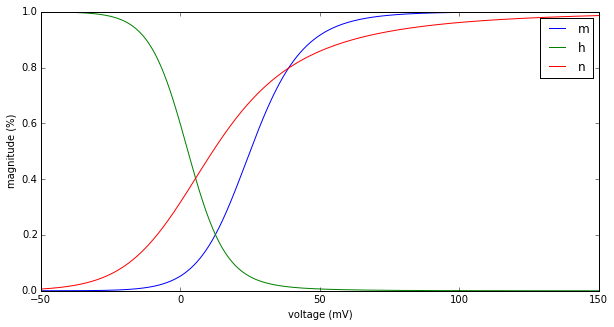

In [14]:
voltage = np.arange(-50, 150, 0.1)
plt.figure(figsize=(10, 5))
plt.plot(voltage, map(m_inf, voltage), label='m')
plt.plot(voltage, map(h_inf, voltage), label='h')
plt.plot(voltage, map(n_inf, voltage), label='n')
plt.xlabel('voltage (mV)')
plt.ylabel('magnitude (%)')
plt.legend()
plt.show()

In [15]:
dt = 0.025
time = np.arange(0, 500, dt)

v = np.zeros(len(time))
m = np.zeros(len(time))
h = np.zeros(len(time))
n = np.zeros(len(time))

v[0] = 0.0
m[0] = m_inf(v[0])
h[0] = h_inf(v[0])
n[0] = n_inf(v[0])

# set injected current
I_inj = np.zeros(len(time))
I_inj[1000:5000] = [5] * 4000
I_inj[7000:11000] = [25] * 4000
I_inj[13000:17000] = [50] * 4000

In [16]:
# simulate model
for i in range(1,len(time)):
    m[i] = m[i-1] + dmdt(v[i-1], m[i-1]) * dt
    h[i] = h[i-1] + dhdt(v[i-1], h[i-1]) * dt
    n[i] = n[i-1] + dndt(v[i-1], n[i-1]) * dt
    v[i] = v[i-1] + dVdt(v[i-1], m[i-1], h[i-1], n[i-1], I_inj[i-1]) * dt

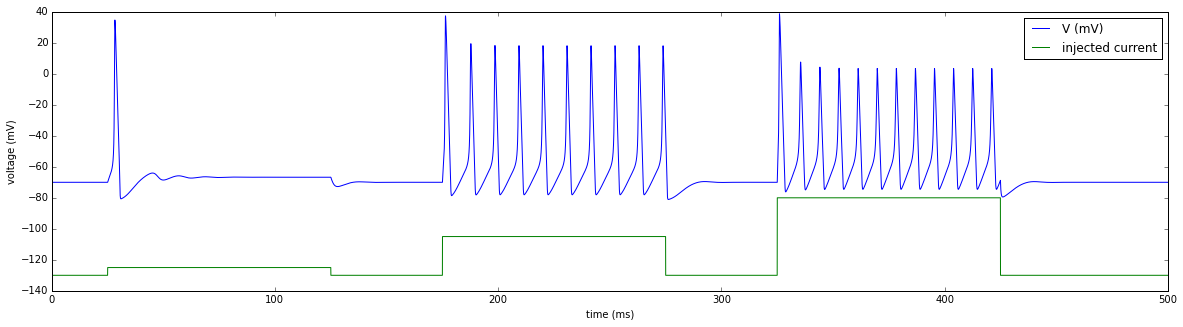

In [17]:
plt.figure(figsize=(20,5))
plt.plot(time, v - 70.0, label='V (mV)')
plt.plot(time, I_inj - 130.0, label='injected current')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')
plt.show()